# Colab Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
"""
Change directory to where this file is located
"""
%cd '/content/drive/MyDrive/MLVU/HW2'

/content/drive/MyDrive/MLVU/HW2


# Import Modules

In [3]:
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow.keras.layers as layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.datasets.cifar10 import load_data

In [4]:
"""
import modules you need
"""
from tensorflow.keras import regularizers


In [5]:
"""
Make sure your runtime type is GPU!
"""
physical_devices = tf.config.list_physical_devices('GPU')
print('Num_GPUs:{}, List:{}'.format(len(physical_devices), physical_devices))

Num_GPUs:1, List:[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Utils

In [6]:
def plot_dataset(images, labels, grid_width, grid_height, figure_width=5, figure_height=5, y_hats=None):
    """
    Plots image and labels.

    Do NOT modify this method.
    """
    f, ax = plt.subplots(grid_height, grid_width)
    f.set_size_inches(figure_width, figure_height)
    img_idx = 0
    for i in range(0, grid_height):
        for j in range(0, grid_width):
            image = images[img_idx]
            label = labels[img_idx]
            title_color = 'k'
            if y_hats is None:
                label_idx = int(label)
            else:
                label_idx = int(y_hats[img_idx])
                if int(labels[img_idx]) != label_idx:
                    title_color = 'r'
            label = InputPipelineBuilder.LABELS[label_idx]
            ax[i][j].axis('off')
            ax[i][j].set_title(label, color=title_color)
            ax[i][j].imshow(image, aspect='auto')
            img_idx += 1
        plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0.25)
    plt.show()

def plot_history(history):
    """
    Plots training history.
    
    Do NOT modify this method.
    """
    plt.plot(history.history['sparse_categorical_accuracy'])
    plt.plot(history.history['val_sparse_categorical_accuracy'])
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

# CIFAR-10 Data Augmentation

In [7]:
class InputPipelineBuilder:
    """
    CIFAR10 Input Pipeline
    """    
    IMG_SIZE = (32,32)
    LABELS = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    
    def __init__(self, valid_size=0.2):
        """
        Loads and splits CIFAR10 to train, validation, and test sets.

        Do NOT modify this method.
        """
        (x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
        x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=valid_size)
        self.x = {'train':x_train, 'valid':x_valid, 'test':x_test}
        self.y = {'train':y_train, 'valid':y_valid, 'test':y_test}
        
    def get_dataset(self, generator, subset='train'):
        """
        Creates a tf.dataset to load input images augmented by the given generator.

        Do NOT modify this method.
        """
        x = self.x[subset]
        y = self.y[subset]
        def gen():
            for images, labels in generator.flow(x, y, batch_size=1, shuffle=False):
                yield images[0], labels[0]
        ds = tf.data.Dataset.from_generator(
            gen, 
            output_signature=(
                tf.TensorSpec(shape=(*InputPipelineBuilder.IMG_SIZE, 3), dtype=tf.float32),
                tf.TensorSpec(shape=(1,), dtype=tf.float32)))
        return ds, len(y)
    
class CustomImageDataGenerator(ImageDataGenerator):
    def __init__(self, filter_size=3, sigma=1.0, prob=0.5, augment=True, **kwargs):
        """
        Inherits TF Image Data Generator for random gaussian smoothing.

        Do NOT modify this method.

        Inputs
        - filter_size
        - sigma
        - prob: a probability to apply gaussian smoothing.
        """
        if augment:
            super(CustomImageDataGenerator, self).__init__(preprocessing_function=self.random_gaussian_smoothing, **kwargs)
        else:
            super(CustomImageDataGenerator, self).__init__(preprocessing_function=None, **kwargs)
        self.filter_size = filter_size
        self.sigma = sigma
        self.prob = prob
    
    def random_gaussian_smoothing(self, image):
        """
        Apply random Gaussian smoothing to the given image.

        Do NOT modify this method.

        Inputs
        - image
        Returns
        - image: augmented image.
        """
        apply = np.random.binomial(1, self.prob)
        if apply:
            return self.gaussian_smoothing(image)
        else:
            return image

    def gaussian_smoothing(self, image):
        """
        Creates a Gaussian filter and applies smoothing to the given image.

        Question (a)
        - You may not use libraries to directly achieve a Gaussian filter. 
        - Use self.filter_size and self.sigma to define the filter.
        - Use cv2.filter2D(image, -1, gaussian_filter) for convolution.

        Inputs
        - image: an input image of shape (32,32,3).
        Returns
        - image: image blurred with a Gaussian Filter.
        """

        H,W = self.filter_size, self.filter_size
        sigma = self.sigma 
        gaussian_filter = np.asarray([[np.exp(-((x-np.ceil(W/2))**2 + (y-np.ceil(H/2))**2)/2*sigma**2) for x in range(1,H+1)] for y in range(1,H+1)])
        gaussian_filter *= (1/(2*np.pi*sigma**2))
        gaussian_filter *= 1/np.sum(gaussian_filter)
        image = cv2.filter2D(image, -1, gaussian_filter)

        return image



In [8]:
"""
Builds a CIFAR10 input pipeline, and performs data augmentation for training data.
"""
input_pipeline_builder = InputPipelineBuilder()

train_generator = CustomImageDataGenerator(filter_size=7, sigma=1.0, prob=0.2,
                                           rescale=1./255, zoom_range=0.1, rotation_range=20,
                                           width_shift_range=0.1, height_shift_range=0.1, shear_range=0.1, 
                                           horizontal_flip=True, fill_mode='nearest')
valid_generator = CustomImageDataGenerator(rescale=1./255, augment=False)
test_generator = CustomImageDataGenerator(rescale=1./255, augment=False)

170508288/170498071 [==============================] - 3s 0us/step


In [9]:
"""
Utilize TF dataset methods to expedite I/O.
"""
batch_size = 64

train_ds_preprocessed, train_steps = input_pipeline_builder.get_dataset(train_generator, subset='train')
valid_ds_preprocessed, valid_steps = input_pipeline_builder.get_dataset(valid_generator, subset='valid')
test_ds_preprocessed, test_steps = input_pipeline_builder.get_dataset(test_generator, subset='test')

train_ds = train_ds_preprocessed.shuffle(1000).batch(16)
valid_ds = valid_ds_preprocessed.batch(16)

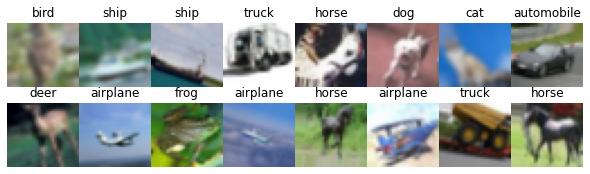

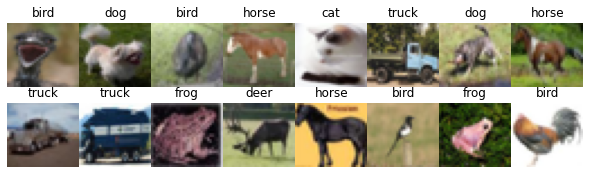

In [10]:
images, labels = next(iter(train_ds.take(1)))
plot_dataset(images, labels, grid_width=8, grid_height=2, figure_width=8, figure_height=2)
images, labels = next(iter(valid_ds.take(1)))
plot_dataset(images, labels, grid_width=8, grid_height=2, figure_width=8, figure_height=2)

# ConvNet Image Classification

In [11]:
def ConvNet(input_shape=(32,32,3)):
    """
    Builds a ConvNet model.
    The model must include BatchNormalization, regularizer, and Dropout.

    Question (b)
    - things that might be useful...
    - stack [Conv2D + Conv2D + MaxPool2D] three times.
    - each Conv2D layer uses filter size = 3x3, kernel_initializer='he_uniform', padding='same'.
      (add more parameters to Conv2D if necessary!)
    - follwed by two Dense layers.
    - channels or units used: [32, 32, 64, 64, 128, 128, 128, 10]
    - The model must include BatchNormalization, regularizers, and Dropout.

    Inputs
    - input_shape: the shape of the input image.
    Returns
    - cnn: a TF Keras Sequential model of ConvNet
    """  
    l2 = 0.0005
    cnn = tf.keras.Sequential()
    #First block
    cnn.add(layers.Conv2D(32, 3, padding="same", kernel_initializer="he_uniform",kernel_regularizer=regularizers.l2(l2)))
    cnn.add(layers.BatchNormalization(axis=1))
    cnn.add(layers.ReLU())
    cnn.add(layers.Conv2D(32, 3, padding="same", kernel_initializer="he_uniform", kernel_regularizer=regularizers.l2(l2)))
    cnn.add(layers.BatchNormalization(axis=1))
    cnn.add(layers.ReLU())
    cnn.add(layers.MaxPool2D(pool_size=(2, 2)))

    #Second Block
    cnn.add(layers.Conv2D(64, 3, padding="same", kernel_initializer="he_uniform", kernel_regularizer=regularizers.l2(l2)))
    cnn.add(layers.BatchNormalization(axis=1))
    cnn.add(layers.ReLU())
    cnn.add(layers.Conv2D(64, 3, padding="same", kernel_initializer="he_uniform", kernel_regularizer=regularizers.l2(l2)))
    cnn.add(layers.BatchNormalization(axis=1))
    cnn.add(layers.ReLU())
    cnn.add(layers.MaxPool2D(pool_size=(2, 2)))

    #Third Block
    cnn.add(layers.Conv2D(128, 3, padding="same", kernel_initializer="he_uniform", kernel_regularizer=regularizers.l2(l2)))
    cnn.add(layers.BatchNormalization(axis=1))
    cnn.add(layers.ReLU())
    cnn.add(layers.Conv2D(128, 3, padding="same", kernel_initializer="he_uniform", kernel_regularizer=regularizers.l2(l2)))
    cnn.add(layers.BatchNormalization(axis=1))
    cnn.add(layers.ReLU())
    cnn.add(layers.MaxPool2D(pool_size=(2, 2)))

    # Go from convolutions to fully connected layers
    cnn.add(layers.Flatten())
    cnn.add(layers.Dropout(rate=0.5))
    cnn.add(layers.Dense(128,activation="relu", kernel_regularizer=regularizers.l2(l2)))
    cnn.add(layers.Dense(10,activation="softmax"))

    
    

    return cnn

In [ ]:
### 
# Question (c)
# Train your ConvNet to achieve test accuracy above 60%
# You can try or add other training options such as SGD or callbacks to schedule learning rates if you want.
###

In [12]:
"""
Utilize TF dataset methods to expedite I/O.
"""
batch_size = 64

train_ds_preprocessed, train_steps = input_pipeline_builder.get_dataset(train_generator, subset='train')
valid_ds_preprocessed, valid_steps = input_pipeline_builder.get_dataset(valid_generator, subset='valid')
test_ds_preprocessed, test_steps = input_pipeline_builder.get_dataset(test_generator, subset='test')

train_ds, train_steps = train_ds_preprocessed.shuffle(1000).batch(64).prefetch(tf.data.experimental.AUTOTUNE), train_steps//batch_size
valid_ds, valid_steps = valid_ds_preprocessed.batch(64).prefetch(tf.data.experimental.AUTOTUNE), valid_steps//batch_size
test_ds, test_steps = test_ds_preprocessed.batch(64).prefetch(tf.data.experimental.AUTOTUNE), test_steps//batch_size

In [13]:
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy()
metric = tf.keras.metrics.SparseCategoricalAccuracy()

cnn = ConvNet()
cnn.compile(optimizer, loss, metrics=metric)

In [14]:
callbacks = []
callbacks.append(tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3))

Epoch 1/20
625/625 [==============================] - 95s 100ms/step - loss: 2.2770 - sparse_categorical_accuracy: 0.2711 - val_loss: 1.8787 - val_sparse_categorical_accuracy: 0.3852
Epoch 2/20
625/625 [==============================] - 63s 101ms/step - loss: 1.8255 - sparse_categorical_accuracy: 0.3965 - val_loss: 1.6205 - val_sparse_categorical_accuracy: 0.4613
Epoch 3/20
625/625 [==============================] - 64s 102ms/step - loss: 1.6331 - sparse_categorical_accuracy: 0.4633 - val_loss: 1.4145 - val_sparse_categorical_accuracy: 0.5353
Epoch 4/20
625/625 [==============================] - 64s 103ms/step - loss: 1.5075 - sparse_categorical_accuracy: 0.5180 - val_loss: 1.2939 - val_sparse_categorical_accuracy: 0.5885
Epoch 5/20
625/625 [==============================] - 65s 105ms/step - loss: 1.4206 - sparse_categorical_accuracy: 0.5564 - val_loss: 1.2829 - val_sparse_categorical_accuracy: 0.5980
Epoch 6/20
625/625 [==============================] - 67s 107ms/step - loss: 1.3579 -

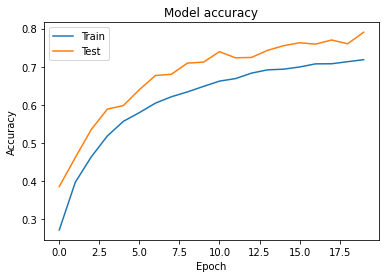

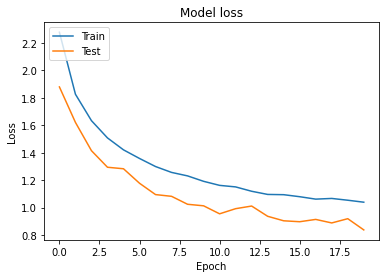

In [15]:
history = cnn.fit(train_ds,
                  steps_per_epoch=train_steps,
                  validation_data=valid_ds,
                  validation_steps=valid_steps,
                  callbacks=callbacks,
                  epochs=20,
                  verbose=1)

plot_history(history)

156/156 [==============================] - 5s 32ms/step - loss: 0.8503 - sparse_categorical_accuracy: 0.7847


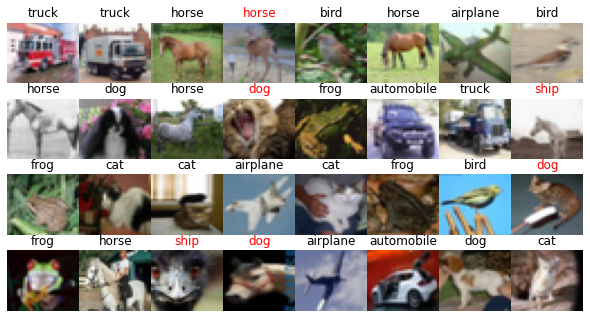

In [16]:
"""
Measure test accuracy
"""
cnn.evaluate(test_ds, steps=test_steps)

images, labels = next(iter(test_ds_preprocessed.shuffle(100).batch(32).take(1)))
y_hats = np.argmax(cnn.predict(images), axis=1)
plot_dataset(images, labels, grid_width=8, grid_height=4, figure_width=8, figure_height=4, y_hats=y_hats)

# ResNet50 Transfer Learning

In [17]:
def conv_block(input_tensor, kernel_size, filters, strides=1, conv_shortcut=False):
    """
    a building block for ResNet50 implemented with TF Keras Functional API.

    Question (d)
    - consists of three [Conv2D+BN]s and a shortcut.
    - if a shortcut needs to match dimensions, apply Conv2D+BN to input_tensor.
    - otherwise, a shortcut is just input_tensor.
    - refer to the figure 2 in the pdf file to place ReLUs.

    Inputs
    - input_tensor: input tensor.
    - kernel_size: filter size
    - filters: a list of the numbers of channels; e.g. [9, 16, 25]
    - strides
    - conv_shortcut: indicates whether a shortcut connection uses a Conv2D.
    Returns
    - x: output tensor
    """
    k = kernel_size
    s = strides
    x_shortcut = input_tensor
    if conv_shortcut:
      x_shortcut = layers.Conv2D(filters[2], kernel_size=(k, k), strides=(s, s), padding='valid')(x_shortcut)
      x_shortcut = layers.BatchNormalization()(x_shortcut) 
    
    # First 
    x = layers.Conv2D(filters[0], (1,1), strides=(s,s) )(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    # Second
    x = layers.Conv2D(filters[1], (3,3), padding = "same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    # Third
    x = layers.Conv2D(filters[2], (1,1))(x)
    x = layers.BatchNormalization()(x)
    
    # Adding
    x = layers.Add()([x, x_shortcut])
    x = layers.Activation("relu")(x)

    return x

def ResNet50(input_shape=(224,224,3)):
    """
    Builds a ResNet50 model.

    Question (d)
    - complete the model from conv2_x to conv5_x.
    - refer to the figure 2 for the overall architecture.

    Inputs
    - input_shape: the shape of the input image.
    Returns
    - a TF Keras Model model of ResNet50
    """
    # input layer
    input_tensor = tf.keras.Input(shape=input_shape)
    
    # conv1
    x = layers.ZeroPadding2D(padding=(3, 3))(input_tensor)
    x = layers.Conv2D(64, (7, 7), strides=(2, 2), padding='valid', kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.ZeroPadding2D(padding=(1, 1))(x)
    
    # conv2_x
    x = layers.MaxPool2D((3,3),strides = (2,2))(x)
    # print(x.shape)
    # Since the shape of x here is 56x56x64 we need the shortcut to go through
    # 1x1 conv with number of filters 256 and stride 1
    x = conv_block(x, 1, [64,64,256], strides=1, conv_shortcut=True)
    x = conv_block(x, 1, [64,64,256], strides=1, conv_shortcut=False)
    x = conv_block(x, 1, [64,64,256], strides=1, conv_shortcut=False)
    #print(x.shape)

    # conv3_x
    # Since the shape here is 56x56x256 and the target shape is 28x28x512
    # We would need a stride of 2 on the first (or last) 1x1 block as well as the shortcut 
    x = conv_block(x, 1, [128,128,512], strides=2, conv_shortcut=True)
    x = conv_block(x, 1, [128,128,512], strides=1, conv_shortcut=False)
    x = conv_block(x, 1, [128,128,512], strides=1, conv_shortcut=False)
    x = conv_block(x, 1, [128,128,512], strides=1, conv_shortcut=False)
    #print(x.shape)

    # conv4_x
    # Since the shape here is 28x28x512 and the target shape is 14x14x1024
    # We would need a stride of 2 on the first (or last) 1x1 block as well as the shortcut
    x = conv_block(x, 1, [256,256,1024], strides=2, conv_shortcut=True)
    x = conv_block(x, 1, [256,256,1024], strides=1, conv_shortcut=False)
    x = conv_block(x, 1, [256,256,1024], strides=1, conv_shortcut=False)
    x = conv_block(x, 1, [256,256,1024], strides=1, conv_shortcut=False)
    x = conv_block(x, 1, [256,256,1024], strides=1, conv_shortcut=False)
    x = conv_block(x, 1, [256,256,1024], strides=1, conv_shortcut=False)
    #print(x.shape)
    # conv5_x
    # Since the shape here is 14x14x1024 and the target shape is 7x7x2048
    # We would need a stride of 2 on the first (or last) 1x1 block as well as the shortcut
    x = conv_block(x, 1, [512,512,2048], strides=2, conv_shortcut=True)
    x = conv_block(x, 1, [512,512,2048], strides=1, conv_shortcut=False)
    x = conv_block(x, 1, [512,512,2048], strides=1, conv_shortcut=False)
    #print(x.shape)
    return tf.keras.Model(input_tensor, x)

In [18]:
###
# Load pretrained weights on ImageNet.
# Use this line to verify your implementation of ResNet50 ***
# If your implementation is right, the model should be able to load the weights.
###
base = ResNet50()
base.load_weights('resnet50_weights_imagenet.h5')

In [19]:
tf.keras.backend.clear_session()

inputs = tf.keras.Input(shape=[32,32,3])
x = tf.keras.layers.UpSampling2D(size=(7,7))(inputs)
x = base(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dense(512, activation='relu')(x)
outputs = layers.Dense(10, activation='softmax')(x)
resnet = tf.keras.Model(inputs, outputs)

In [ ]:
### 
# Question (e)
# Train your ResNet50 to achieve test accuracy above 90%
# You can try or add other training options such as Adam or callbacks to schedule learning rates if you want.
###

In [20]:
"""
Utilize TF dataset methods to expedite I/O.
"""
batch_size = 64

train_ds_preprocessed, train_steps = input_pipeline_builder.get_dataset(train_generator, subset='train')
valid_ds_preprocessed, valid_steps = input_pipeline_builder.get_dataset(valid_generator, subset='valid')
test_ds_preprocessed, test_steps = input_pipeline_builder.get_dataset(test_generator, subset='test')

train_ds, train_steps = train_ds_preprocessed.shuffle(1000).batch(64).prefetch(tf.data.experimental.AUTOTUNE), train_steps//batch_size
valid_ds, valid_steps = valid_ds_preprocessed.batch(64).prefetch(tf.data.experimental.AUTOTUNE), valid_steps//batch_size
test_ds, test_steps = test_ds_preprocessed.batch(64).prefetch(tf.data.experimental.AUTOTUNE), test_steps//batch_size

In [21]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
loss = tf.keras.losses.SparseCategoricalCrossentropy()
metric = tf.keras.metrics.SparseCategoricalAccuracy()

resnet.compile(optimizer, loss, metrics=metric)

In [22]:
callbacks = []
callbacks.append(tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3))

Epoch 1/3
625/625 [==============================] - 891s 1s/step - loss: 0.9011 - sparse_categorical_accuracy: 0.6881 - val_loss: 2.7735 - val_sparse_categorical_accuracy: 0.1968
Epoch 2/3
625/625 [==============================] - 878s 1s/step - loss: 0.3817 - sparse_categorical_accuracy: 0.8679 - val_loss: 0.2586 - val_sparse_categorical_accuracy: 0.9093
Epoch 3/3
625/625 [==============================] - 872s 1s/step - loss: 0.2851 - sparse_categorical_accuracy: 0.9010 - val_loss: 0.2145 - val_sparse_categorical_accuracy: 0.9269


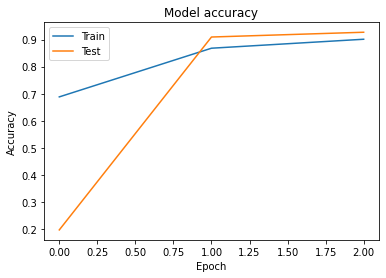

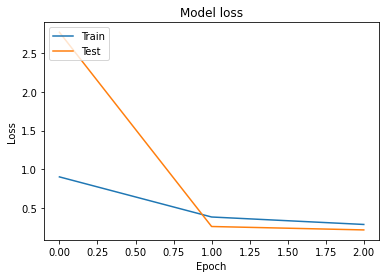

In [23]:
history = resnet.fit(train_ds,
                     steps_per_epoch=train_steps,
                     validation_data=valid_ds,
                     validation_steps=valid_steps,
                     callbacks=callbacks,
                     epochs=3,
                     verbose=1)
plot_history(history)

156/156 [==============================] - 63s 404ms/step - loss: 0.2290 - sparse_categorical_accuracy: 0.9261


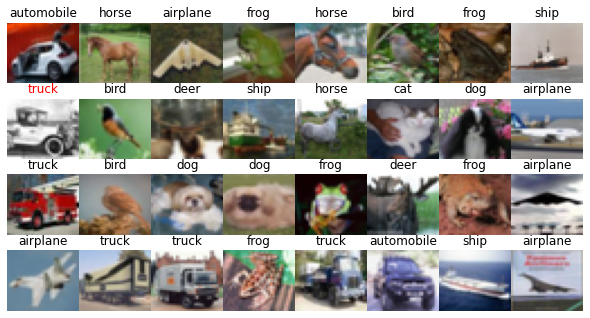

In [24]:
"""
Measure test accuracy
"""
resnet.evaluate(test_ds, steps=test_steps)

images, labels = next(iter(test_ds_preprocessed.shuffle(100).batch(32).take(1)))
y_hats = np.argmax(resnet.predict(images), axis=1)
plot_dataset(images, labels, grid_width=8, grid_height=4, figure_width=8, figure_height=4, y_hats=y_hats)